### Оптимизация маркетинговых затрат в Яндекс.Афише

Цель: изучить как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается. Оптимизация маркетинкоговых расходов.


### Вывод

1. Самая низкая стоимость привлечения клиента у источников 4, 10, 2 и 1. Самая высокая - у 3 источника.
2. Показатель возврата на маркетинговые инвестиции показывает, что окупились только 2 рекламных источника: 1 и 2.
3. Коэффициент удержания находится на весьма низком уровне.


### Ключевые понятия
Matplotlib, Pandas, Python, когортный анализ, продуктовые метрики, юнит-экономика.


### Описание данных

#### Таблица visits (лог сервера с информацией о посещениях сайта):
- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь

#### Таблица orders (информация о заказах):
- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа

#### Таблица costs (информация о затратах на маркетинг):
- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день


[Загрузим данные и подготовим их к анализу](#step1)


[Построим отчёты и посчитаем метрики](#step2)


Продукт
- Сколько людей пользуются в день, неделю, месяц?
- Сколько сессий в день?
- Сколько длится одна сессия?
- Как часто люди возвращаются?

Продажи
- Когда люди начинают покупать?
- Сколько раз покупают за период?
- Какой средний чек?
- Сколько денег приносят? (LTV)

Маркетинг
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько стоило привлечение одного покупателя из каждого источника?
- На сколько окупились расходы? (ROI)
- Отобразим на графиках, как эти метрики отличаются по устройствам и по рекламным источникам? Как они меняются во времени?


[Напишем общий вывод](#step3)

### Загрузим данные и подготовим их к анализу <a id="step1"></a>   

In [1]:
# импортируем библиотеки, которые потребуются нам для работы
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
visits = pd.read_csv('/home/ilya/Desktop/Datasets/Yandex_affiche/visits_log.csv')
visits.info()
visits.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


In [3]:
# с помощью метода describe() посмотрим какие отклонения есть в данных
visits.describe()

,Source Id,Uid
count,359400.000000,3.594000e+05
mean,3.750515,9.202557e+18
std,1.917116,5.298433e+18
min,1.000000,1.186350e+13
25%,3.000000,4.613407e+18
50%,4.000000,9.227413e+18
75%,5.000000,1.372824e+19
max,10.000000,1.844668e+19


In [4]:
# методом duplicated().sum проверим есть ли дубликаты в таблице
visits.duplicated().sum

<bound method Series.sum of 0         False
1         False
2         False
3         False
4         False
          ...  
359395    False
359396    False
359397    False
359398    False
359399    False
Length: 359400, dtype: bool>

Названия колонок с заглавной буквы. Приведём всё к нижнему регистру и уберём пробелы.

Столбцы End Ts и Start Ts имеют тип данных object, преобразуем значения столбцов к типу datetime.

Всего в таблице 359400 строк и 5 колонок.

Пропусков в таблице нет. 

Отрицательных значений в столбцах нет.

Дубликатов в таблице нет.

In [5]:
# переименуем столбцы так, чтобы не было пробелов в названиях и заглавных букв
# visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
visits = visits.rename(columns={'Device':'device', 'End Ts':'end_ts', 'Source Id':'source_id', 
                                'Start Ts':'start_ts', 'Uid':'uid'})
# проверим успешно ли прошла замена
visits.columns

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

In [6]:
# переведём столбцы типа object к типу datetime64
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format='%Y-%m-%d %H:%M:%S')
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format='%Y-%m-%d %H:%M:%S')
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [7]:
orders = pd.read_csv('/home/ilya/Desktop/Datasets/Yandex_affiche/orders_log.csv')
orders.info()
orders.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


In [8]:
# с помощью метода describe() посмотрим какие отклонения есть в данных
orders.describe()

,Revenue,Uid
count,50415.000000,5.041500e+04
mean,4.999647,9.098161e+18
std,21.818359,5.285742e+18
min,0.000000,3.135781e+14
25%,1.220000,4.533567e+18
50%,2.500000,9.102274e+18
75%,4.890000,1.368290e+19
max,2633.280000,1.844617e+19


In [9]:
# методом duplicated().sum проверим есть ли дубликаты в таблице
orders.duplicated().sum

<bound method Series.sum of 0        False
1        False
2        False
3        False
4        False
         ...  
50410    False
50411    False
50412    False
50413    False
50414    False
Length: 50415, dtype: bool>

Названия колонок с заглавной буквы. Приведём всё к нижнему регистру и уберём пробелы.

Столбец Buy Ts имеет тип данных object, преобразуем значение столбца к типу datetime64.

Всего в таблице 50415 строк и 3 колонки.

Пропусков в таблице нет.

Отрицательных значений в столбцах нет.

Дубликатов в таблице нет.

In [10]:
# переименуем столбцы так, чтобы не было пробелов в названиях и заглавных букв
# orders.columns = ['buy_ts', 'revenue', 'uid']
orders = orders.rename(columns={'Buy Ts':'buy_ts', 'Revenue':'revenue', 'Uid':'uid'})
# проверим успешно ли прошла замена
orders.columns

Index(['buy_ts', 'revenue', 'uid'], dtype='object')

In [11]:
# переведём столбец buy_ts типа object к типу datetime64
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format='%Y-%m-%d %H:%M:%S')
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [12]:
costs = pd.read_csv('/home/ilya/Desktop/Datasets/Yandex_affiche/costs.csv')
costs.info()
costs.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


In [13]:
# с помощью метода describe() посмотрим какие отклонения есть в данных
costs.describe()

,source_id,costs
count,2542.000000,2542.000000
mean,4.857199,129.477427
std,3.181581,156.296628
min,1.000000,0.540000
25%,2.000000,21.945000
50%,4.000000,77.295000
75%,9.000000,170.065000
max,10.000000,1788.280000


In [14]:
# методом duplicated().sum проверим есть ли дубликаты в таблице
costs.duplicated().sum

<bound method Series.sum of 0       False
1       False
2       False
3       False
4       False
        ...  
2537    False
2538    False
2539    False
2540    False
2541    False
Length: 2542, dtype: bool>

Названия колонок с написаны нижним регистром, пробелов нет. Изменений не требуется.

Столбец dt имеет тип данных object, преобразуем значение столбца к типу datetime64.

Всего в таблице 2542 строк и 3 колонки.

Пропусков в таблице нет.

Отрицательных значений в столбцах нет.

Дубликатов в таблице нет.

In [15]:
# переведём столбец dt типа object к типу datetime64
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d %H:%M:%S')
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


### Построим отчёты и посчитаем метрики <a id="step2"></a>   

### Продукт
#### Сколько людей пользуются в день, неделю, месяц?

In [16]:
# Чтобы посчитать недельное и месячное использование, 
# выделим в отдельные столбцы год, месяц и неделю, а также полную дату.
visits['session_year']  = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week']  = visits['start_ts'].dt.isocalendar().week
visits['session_date'] = visits['start_ts'].dt.date
visits.head(10)

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017,9,35,2017-09-03
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,2018,1,5,2018-01-30
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312,2017,11,44,2017-11-05
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644,2017,7,29,2017-07-19
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063,2017,11,45,2017-11-08


In [17]:
dau_total = visits.groupby('session_date').agg({'uid': 'nunique'}).mean()
wau_total = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean()
mau_total = visits.groupby(['session_year', 'session_month']).agg({'uid':'nunique'}).mean()

In [18]:
print('В день Яндекс.Афишей пользуется', int(dau_total), 'человек')
print('В неделю Яндекс.Афишей пользуется', int(wau_total), 'человек')
print('В месяц Яндекс.Афишей пользуется', int(mau_total), 'человек')

В день Яндекс.Афишей пользуется 907 человек
В неделю Яндекс.Афишей пользуется 5716 человек
В месяц Яндекс.Афишей пользуется 23228 человек


#### Сколько сессий в день?

In [19]:
# посчитаем сколько сессий в день приходится на одного пользователя
sessions_per_user = visits.groupby('session_date').agg({'uid': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
sessions_per_user.head(10)

,n_sessions,n_users,sessions_per_user
session_date,,,
2017-06-01,664,605,1.097521
2017-06-02,658,608,1.082237
2017-06-03,477,445,1.071910
2017-06-04,510,476,1.071429
2017-06-05,893,820,1.089024
2017-06-06,875,797,1.097867
2017-06-07,788,699,1.127325
2017-06-08,939,868,1.081797
2017-06-09,755,695,1.086331


In [20]:
sessions_per_user['sessions_per_user'].describe()

count    364.000000
mean       1.082170
std        0.020876
min        1.000000
25%        1.070321
50%        1.082488
75%        1.093876
max        1.217837
Name: sessions_per_user, dtype: float64

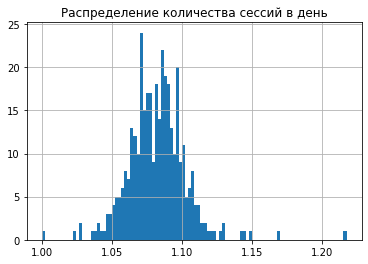

In [21]:
# посмотрим на распределение
sessions_per_user['sessions_per_user'].hist(bins=100);
plt.title('Распределение количества сессий в день');
# распределение нормальное

In [22]:
print('В среднем пользователь Андекс.Афиши пользуется сервисом', 
      sessions_per_user['sessions_per_user'].mean().round(1), 'раз в день')

В среднем пользователь Андекс.Афиши пользуется сервисом 1.1 раз в день


#### Сколько длится одна сессия?

In [23]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
print('Средняя продолжительность сессии', visits['session_duration_sec'].mean().round(1), 'секунд')

Средняя продолжительность сессии 643.5 секунд


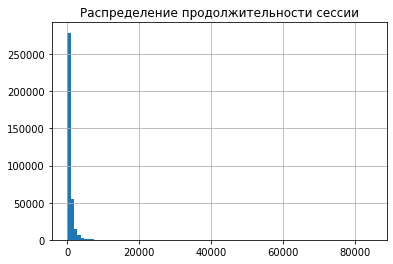

In [24]:
# посмотрим на распределение
visits['session_duration_sec'].hist(bins=90);
plt.title('Распределение продолжительности сессии');

Когда распределение близко к нормальному или нормальное — можно смотреть на среднюю или медиану. Наше — не из таких, рассчитаем моду (значение в выборке, которое встречается чаще всего):

In [25]:
visits['session_duration_sec'].mode()

0    60
dtype: int64

Самое частовстречающееся значение длительности пользовательской сессии 60 секунд, что достаточно мало.

#### Как часто люди возвращаются?
Чтобы ответить на вопрос как часто люди возвращаются к продукту, рассчитаем Retention Rate (коэффициент удержания). Определим событие и период — на их основе сформируем когорту. Возьмём дату, когда пользователь впервые проявил активность. Эти данные запишем в объект Series first_activity_date. Объединим его с исходным датафреймом orders.

In [26]:
visits['session_date'] = pd.to_datetime(visits['session_date'])
first_activity_date = visits.groupby(['uid'])['session_date'].min()
first_activity_date.name = 'first_activity_date'
visits = visits.join(first_activity_date, on = 'uid')
visits.head(10)

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_duration_sec,first_activity_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440,2018-03-09
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,0,2017-12-27
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017,9,35,2017-09-03,60,2017-09-03
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,2018,1,5,2018-01-30,3360,2017-06-29
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312,2017,11,44,2017-11-05,60,2017-11-05
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644,2017,7,29,2017-07-19,180,2017-07-19
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063,2017,11,45,2017-11-08,60,2017-11-08


In [27]:
visits['cohort_lifetime'] = visits['session_date'] - visits['first_activity_date']

Теперь для каждой строки датафрейма можно рассчитать lifetime пользователя в рамках когорты. 

In [28]:
# visits['cohort_lifetime'] = visits['activity_month'] - visits['first_activity_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

In [29]:
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')
visits['activity_month'] = visits['session_date'].astype('datetime64[M]')

Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей на определённый «месяц жизни».

In [30]:
cohorts = visits.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

Чтобы найти Retention Rate, нужно сперва получить число пользователей, изначально бывших в когорте, и на него разделить число пользователей в каждую следующую неделю. Найдём исходное количество пользователей в когорте. Возьмём их число на нулевую неделю

In [31]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]

In [32]:
# Переименуем столбец uid в cohort_users методом rename()
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
cohorts = cohorts.merge(initial_users_count, on = 'first_activity_month')

In [33]:
# посчитаем retention_rate
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

In [34]:
retention_pivot = cohorts.pivot_table(index='first_activity_month', columns = 'cohort_lifetime',
                                      values ='retention', aggfunc='sum')
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12
first_activity_month,,,,,,,,,,,,,
2017-06-01,1.0,0.073610,0.054152,0.060713,0.068633,0.067200,0.063655,0.056037,0.055660,0.050230,0.041255,0.040275,0.012595
2017-07-01,1.0,0.056240,0.052359,0.053196,0.056164,0.049315,0.044673,0.049696,0.036758,0.029604,0.023973,0.005479,NaN
2017-08-01,1.0,0.068952,0.062175,0.058737,0.050781,0.042825,0.041057,0.034378,0.028976,0.023377,0.002848,NaN,NaN
2017-09-01,1.0,0.075670,0.067289,0.048910,0.039511,0.040230,0.033046,0.026102,0.019816,0.002574,NaN,NaN,NaN
2017-10-01,1.0,0.073103,0.052970,0.037995,0.036109,0.031374,0.021096,0.017977,0.003234,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.068739,0.046829,0.038278,0.031342,0.024222,0.018497,0.002752,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.050974,0.041080,0.028930,0.021569,0.016384,0.002770,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.053439,0.036289,0.025548,0.017150,0.001945,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.047889,0.026850,0.018020,0.002027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


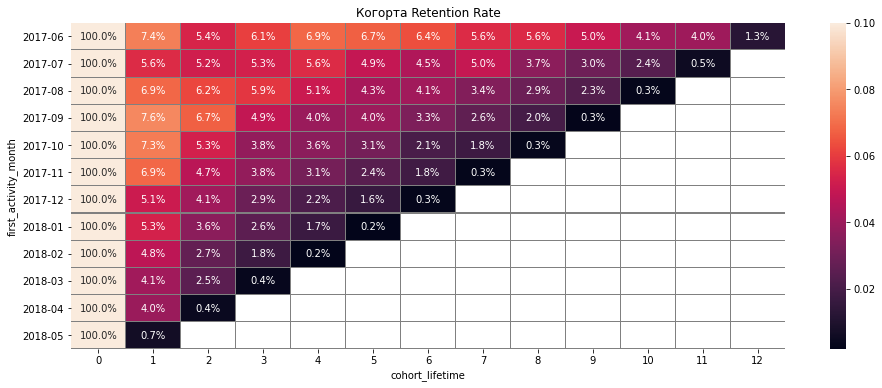

In [35]:
plt.figure(figsize=(16, 6));
plt.title('Когорта Retention Rate');
plt.ylabel('Месяц первой активности');
plt.xlabel('Время жизни когорты');
ax=sns.heatmap(retention_pivot, annot = True, fmt = '.1%', linewidths = 0.02, linecolor='gray', 
            vmax = .1);
ax.set_yticklabels(retention_pivot.index.strftime('%Y-%m'));

Retention Rate в первый месяц держится примерно на одинаковом уровне, для когорт пришедших до ноября 2017 года включительно. Затем начинается заметное падение по когортам с течением времени. Если для когорты пользователей, пришедших в июле Retention Rate в первый месяц составил 7,4%, то для пользователей, пришедших в декабре — уже 5,1%. Так, за 6 месяцев коэффициент удержания упал на 2,3%. Это говорит, что с каждой новой когортой поведение покупателей меняется.

Также стоит отметить, что коэффициент удержания в принципе низкий. Это говорит о том, что совсем небольшое количество людей совершает повторные покупки в Яндекс.Афише.

### Продажи
#### Когда люди начинают покупать?

Чтобы ответить на тот вопрос Найдем разницу между первым визитом на сайт и первой покупкой.

In [36]:
# создадим таблицу с первым визитом и первой покупкой
firs_order_day = orders.groupby('uid').agg({'buy_ts': 'min'}).rename(columns={'buy_ts': 'firs_order_day'})\
.reset_index()
firs_visit_day = visits.groupby('uid').agg({'start_ts': 'min'}).rename(columns={'start_ts': 'firs_visit_day'})\
.reset_index()
order_len = firs_visit_day.merge(firs_order_day, on='uid')

In [37]:
order_len['order_day'] = order_len['firs_order_day'].astype('datetime64[D]')
order_len['session_day'] = order_len['firs_visit_day'].astype('datetime64[D]')

In [38]:
# найдём время от визита до первой покупки в минутах
order_len['order_start_min'] = (((order_len['order_day'] - order_len['session_day'])/np.timedelta64(1, 's'))\
                                .astype(int))/60
order_len.head(10)

,uid,firs_visit_day,firs_order_day,order_day,session_day,order_start_min
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,2018-01-03,2017-09-18,154080.0
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,2017-06-03,2017-06-03,0.0
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,2017-10-11,2017-10-11,0.0
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,2018-01-28,2018-01-27,1440.0
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,2017-11-24,2017-11-24,0.0
5,3077748354309989,2018-03-03 12:08:00,2018-03-03 12:33:00,2018-03-03,2018-03-03,0.0
6,3605148382144603,2017-08-15 21:54:00,2017-09-21 20:56:00,2017-09-21,2017-08-15,53280.0
7,3753586865891862,2018-03-03 13:47:00,2018-03-03 13:50:00,2018-03-03,2018-03-03,0.0
8,4808417689019433,2018-01-09 23:10:00,2018-01-09 23:32:00,2018-01-09,2018-01-09,0.0
9,4992223027560440,2018-04-04 13:54:00,2018-04-04 13:54:00,2018-04-04,2018-04-04,0.0


In [39]:
order_len['order_start_min'].describe()

count     36523.000000
mean      24330.097747
std       67782.528263
min           0.000000
25%           0.000000
50%           0.000000
75%        2880.000000
max      522720.000000
Name: order_start_min, dtype: float64

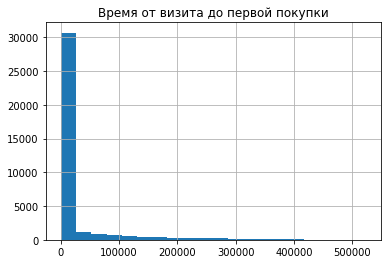

In [40]:
order_len['order_start_min'].hist(bins=20);
plt.title('Время от визита до первой покупки');

In [41]:
# Распределение не является нормальным. Поэтому рассчитаем моду.
order_len['order_start_min'].mode()

0    0.0
dtype: float64

In [42]:
order_len['order_start_min'].median()

0.0

Видим, что покупки производятся практически моментально. 

#### Теперь выясним сколько раз покупают за период. 

In [43]:
first_order_date_by_customers = orders.groupby('uid')['buy_ts'].min() 
first_order_date_by_customers.head(10)

uid
313578113262317    2018-01-03 21:51:00
1575281904278712   2017-06-03 10:13:00
2429014661409475   2017-10-11 18:33:00
2464366381792757   2018-01-28 15:54:00
2551852515556206   2017-11-24 10:14:00
3077748354309989   2018-03-03 12:33:00
3605148382144603   2017-09-21 20:56:00
3753586865891862   2018-03-03 13:50:00
4808417689019433   2018-01-09 23:32:00
4992223027560440   2018-04-04 13:54:00
Name: buy_ts, dtype: datetime64[ns]

In [44]:
first_order_date_by_customers.name = 'first_order_date'

In [45]:
orders = orders.join(first_order_date_by_customers,on='uid')
orders.head(10)

,buy_ts,revenue,uid,first_order_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01 08:43:00
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01 08:54:00
7,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01 09:22:00
8,2017-06-01 09:22:00,3.30,17542070709969841479,2017-06-01 09:22:00
9,2017-06-01 09:23:00,0.37,1074355127080856382,2017-06-01 09:23:00


In [46]:
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
orders.head(10)

,buy_ts,revenue,uid,first_order_date,first_order_month,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01 08:43:00,2017-06-01,2017-06-01
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01 08:54:00,2017-06-01,2017-06-01
7,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01 09:22:00,2017-06-01,2017-06-01
8,2017-06-01 09:22:00,3.30,17542070709969841479,2017-06-01 09:22:00,2017-06-01,2017-06-01
9,2017-06-01 09:23:00,0.37,1074355127080856382,2017-06-01 09:23:00,2017-06-01,2017-06-01


In [47]:
# создадим сводную таблицу, в которой отразим сколько заказов сделал каждый пользователь в месяц
number_of_orders = orders.pivot_table(index='first_order_month',
    columns='order_month',
    values='uid',
    aggfunc='nunique')
number_of_orders

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,2023.0,61.0,50.0,54.0,88.0,67.0,62.0,47.0,58.0,45.0,45.0,53.0,NaN
2017-07-01,NaN,1923.0,52.0,57.0,64.0,49.0,38.0,36.0,39.0,42.0,22.0,26.0,NaN
2017-08-01,NaN,NaN,1370.0,58.0,53.0,44.0,40.0,32.0,30.0,44.0,19.0,31.0,NaN
2017-09-01,NaN,NaN,NaN,2581.0,130.0,100.0,74.0,52.0,64.0,66.0,37.0,43.0,NaN
2017-10-01,NaN,NaN,NaN,NaN,4340.0,206.0,123.0,92.0,93.0,72.0,56.0,67.0,NaN
2017-11-01,NaN,NaN,NaN,NaN,NaN,4081.0,222.0,120.0,106.0,81.0,48.0,62.0,NaN
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,4383.0,146.0,103.0,97.0,50.0,63.0,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3373.0,114.0,83.0,43.0,45.0,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3651.0,118.0,58.0,39.0,NaN


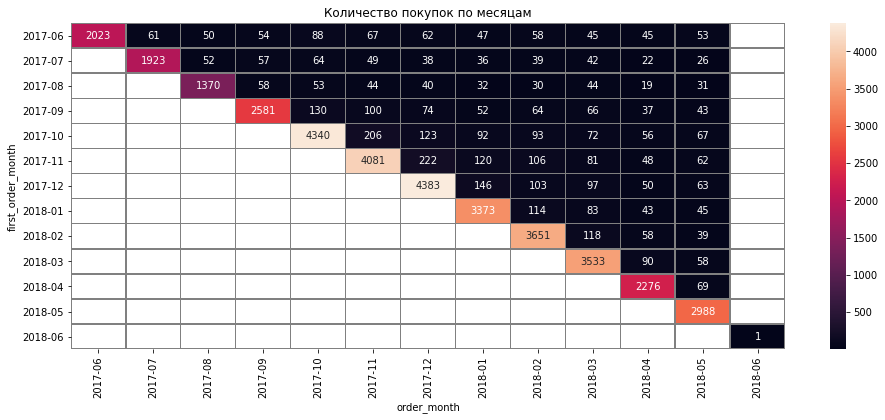

In [48]:
plt.figure(figsize=(16, 6));
plt.title('Количество покупок по месяцам');
ax=sns.heatmap(number_of_orders, annot=True, fmt='.0f', linewidths=0.5, linecolor='gray');
ax.set_yticklabels(number_of_orders.index.strftime('%Y-%m'));
ax.set_xticklabels(number_of_orders.index.strftime('%Y-%m'));

Судя по графику видим, что большинство пользователей делали покупки в первый месяц. Затем число покупок резко падает. Так мы видим, что в июньской когорте в первый же месяц было сделано 2023 покупки, тогда как в следующем месяце число покупок составило 61. А это в 33 раза меньше. Собственно коэффициент удержания говорил именно об этом, учитывая его низкий уровень. Эта имнно та метрика над которой стоит работать.

Исходя из графика можно сделать вывод о том, что летом происходит меньше покупок, чем в другие времена года. Это может быть связано с периодом отпусков.

#### Выясним каков средний чек покупки.

In [49]:
orders_grouped_by_cohorts = orders.groupby(['first_order_month', 'order_month'])\
.agg({'uid':'nunique','revenue':'sum'}).reset_index()
orders_grouped_by_cohorts['revenue_per_user'] = orders_grouped_by_cohorts['revenue']\
/ orders_grouped_by_cohorts['uid']

In [50]:
# Построим сводную таблицу изменения среднего чека в когортах по месяцу совершения покупки и оценим, 
# как изменяется средний чек с течением времени
orders_grouped_by_cohorts.pivot_table(index='first_order_month', columns='order_month', values='revenue_per_user', 
                                      aggfunc='mean')

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,4.724414,16.095410,17.706800,35.764815,23.506591,22.207761,31.011935,25.033191,19.295690,27.233556,25.681333,9.804151,NaN
2017-07-01,NaN,6.010218,12.396346,21.035965,10.786094,6.938163,7.896842,6.421111,6.992821,7.382143,12.861818,11.513846,NaN
2017-08-01,NaN,NaN,5.276518,11.148793,11.851321,12.182955,16.921250,12.139063,9.620333,12.610455,21.070000,8.307419,NaN
2017-09-01,NaN,NaN,NaN,5.644529,22.188385,13.445200,138.669189,19.881538,26.095000,27.437121,16.961351,11.044651,NaN
2017-10-01,NaN,NaN,NaN,NaN,5.003733,11.287427,6.753252,7.413152,7.072796,7.255139,6.573214,7.479701,NaN
2017-11-01,NaN,NaN,NaN,NaN,NaN,5.154683,7.339054,6.786583,12.510660,7.457284,4.580833,7.564839,NaN
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,4.738191,7.816575,39.366019,48.135052,27.431400,23.518413,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.135636,8.721228,12.365542,11.199767,4.699556,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.156987,8.610000,4.942414,6.941026,NaN


In [51]:
# Найдём lifetime когорты. Из месяца совершения заказа order_month вычтем месяц когорты first_order_month
orders_grouped_by_cohorts = orders_grouped_by_cohorts.reset_index()
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['order_month']\
- orders_grouped_by_cohorts['first_order_month']
orders_grouped_by_cohorts['cohort_lifetime'].head()

0     0 days
1    30 days
2    61 days
3    92 days
4   122 days
Name: cohort_lifetime, dtype: timedelta64[ns]

In [52]:
# cohort_lifetime нужно разделим на константу np.timedelta64(1, 'M') и узнаем, сколько величин длиной в 1 месяц 
# содержится в cohort_lifetime
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'] / np.timedelta64(1,'M')
orders_grouped_by_cohorts['cohort_lifetime'].head(10)

0    0.000000
1    0.985647
2    2.004148
3    3.022649
4    4.008296
5    5.026797
6    6.012444
7    7.030945
8    8.049447
9    8.969383
Name: cohort_lifetime, dtype: float64

In [53]:
# Округлим значения столбца cohort_lifetime методом round(), 
# а затем приведём их к целочисленному типу методом astype('int')
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'].round().astype('int')
orders_grouped_by_cohorts[['first_order_month','order_month','cohort_lifetime']].head()

,first_order_month,order_month,cohort_lifetime
0,2017-06-01,2017-06-01,0
1,2017-06-01,2017-07-01,1
2,2017-06-01,2017-08-01,2
3,2017-06-01,2017-09-01,3
4,2017-06-01,2017-10-01,4


In [54]:
orders_grouped_by_cohorts[['first_order_month','order_month','cohort_lifetime']].tail()

,first_order_month,order_month,cohort_lifetime
74,2018-03-01,2018-05-01,2
75,2018-04-01,2018-04-01,0
76,2018-04-01,2018-05-01,1
77,2018-05-01,2018-05-01,0
78,2018-06-01,2018-06-01,0


In [55]:
# Оставим в данных о месяце первого заказа только год и месяц. Применим метод dt.strftime()
orders_grouped_by_cohorts['first_order_month'].dt.strftime('%d.%m.%Y').head(10)

0    01.06.2017
1    01.06.2017
2    01.06.2017
3    01.06.2017
4    01.06.2017
5    01.06.2017
6    01.06.2017
7    01.06.2017
8    01.06.2017
9    01.06.2017
Name: first_order_month, dtype: object

In [56]:
orders_grouped_by_cohorts['first_order_month'] = orders_grouped_by_cohorts['first_order_month']\
.dt.strftime('%Y-%m')

In [57]:
revenue_per_user_pivot = orders_grouped_by_cohorts\
.pivot_table(index='first_order_month', columns='cohort_lifetime', values='revenue_per_user',aggfunc='mean')
revenue_per_user_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,4.724414,16.095410,17.706800,35.764815,23.506591,22.207761,31.011935,25.033191,19.295690,27.233556,25.681333,9.804151
2017-07,6.010218,12.396346,21.035965,10.786094,6.938163,7.896842,6.421111,6.992821,7.382143,12.861818,11.513846,NaN
2017-08,5.276518,11.148793,11.851321,12.182955,16.921250,12.139063,9.620333,12.610455,21.070000,8.307419,NaN,NaN
2017-09,5.644529,22.188385,13.445200,138.669189,19.881538,26.095000,27.437121,16.961351,11.044651,NaN,NaN,NaN
2017-10,5.003733,11.287427,6.753252,7.413152,7.072796,7.255139,6.573214,7.479701,NaN,NaN,NaN,NaN
2017-11,5.154683,7.339054,6.786583,12.510660,7.457284,4.580833,7.564839,NaN,NaN,NaN,NaN,NaN
2017-12,4.738191,7.816575,39.366019,48.135052,27.431400,23.518413,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,4.135636,8.721228,12.365542,11.199767,4.699556,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,4.156987,8.610000,4.942414,6.941026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


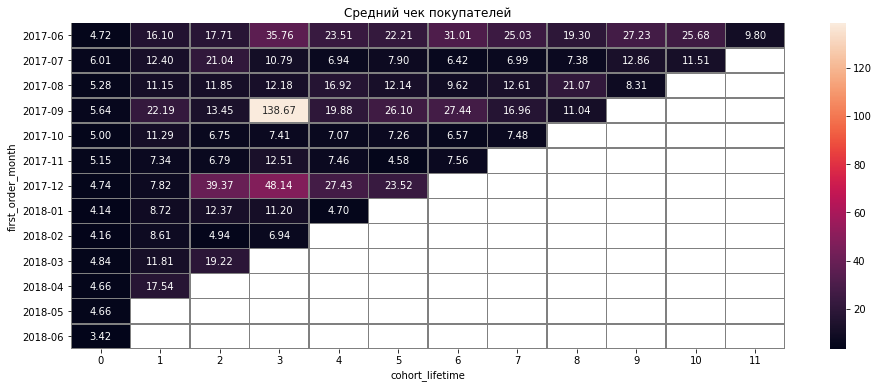

In [58]:
plt.figure(figsize=(16, 6));
plt.title('Средний чек покупателей');
sns.heatmap(revenue_per_user_pivot, annot=True, fmt='.2f', linewidths=0.5, linecolor='gray');

Средний чек когорты июня 2017 выделяется. Особенно это изменение проявляется на 3 месяц lifetime. Интересное поведение демонстрирует когорта сентября 2017: там резко возрастает средний чек покупателей на третий месяц. Возможно, это связано с крупным корпоративным заказом. Также выделяется когорта декабря на 2-й и 3-й месяц lifetime, что эквивалентно февралю и марту. Возможно в эти месяцы многие совершали покупки в качестве подарков на 14 и 23 февраля, а также 8 марта.

In [59]:
orders['revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

In [60]:
# есть очень большие суммы покупок. Поэтому найдём медиану, чтобы понять каков средний чек
print('Средний чек Яндекс.Афиши', orders['revenue'].median())

Средний чек Яндекс.Афиши 2.5


#### Сколько денег приносят?

Для того чтобы ответить на этот вопрос, посчитаем LTV — итоговую сумму денег, которую один клиент приносит в среднем со всех своих покупок.

In [61]:
orders.head(10)

,buy_ts,revenue,uid,first_order_date,first_order_month,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01 08:43:00,2017-06-01,2017-06-01
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01 08:54:00,2017-06-01,2017-06-01
7,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01 09:22:00,2017-06-01,2017-06-01
8,2017-06-01 09:22:00,3.30,17542070709969841479,2017-06-01 09:22:00,2017-06-01,2017-06-01
9,2017-06-01 09:23:00,0.37,1074355127080856382,2017-06-01 09:23:00,2017-06-01,2017-06-01


In [62]:
orders['buy_ts'].describe()

<ipython-input-62-33a8dd77b0b6>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  orders['buy_ts'].describe()


count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: buy_ts, dtype: object

In [63]:
costs['dt'].describe()

<ipython-input-63-7bd2c2bc0743>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  costs['dt'].describe()


count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object

Дата первой покупки и первых затрат на мартетинг совпадают. В то время как дата последней покупки 01-06-2018 (была всего одна покупка), а дата последних вложений на маркетинг была днём раньше 31-05-2018

In [64]:
# Данные за год. Сформируем месячные когорты. Выделим месяцы из дат в таблицах с заказами и расходами
costs['month'] = costs['dt'].astype('datetime64[M]')

In [65]:
# Посчитаем количество новых покупателей (n_buyers) за каждый месяц
cohort_sizes = orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes.head(10)

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


In [66]:
cohorts = orders.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
cohorts.head(10)

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58
5,2017-06-01,2017-11-01,1487.92
6,2017-06-01,2017-12-01,1922.74
7,2017-06-01,2018-01-01,1176.56
8,2017-06-01,2018-02-01,1119.15
9,2017-06-01,2018-03-01,1225.51


In [67]:
# Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
report.head(10)

,first_order_month,n_buyers,order_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58
5,2017-06-01,2023,2017-11-01,1487.92
6,2017-06-01,2023,2017-12-01,1922.74
7,2017-06-01,2023,2018-01-01,1176.56
8,2017-06-01,2023,2018-02-01,1119.15
9,2017-06-01,2023,2018-03-01,1225.51


In [68]:
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report.head(10)

,first_order_month,n_buyers,order_month,revenue,age
0,2017-06-01,2023,2017-06-01,9557.49,0
1,2017-06-01,2023,2017-07-01,981.82,1
2,2017-06-01,2023,2017-08-01,885.34,2
3,2017-06-01,2023,2017-09-01,1931.30,3
4,2017-06-01,2023,2017-10-01,2068.58,4
5,2017-06-01,2023,2017-11-01,1487.92,5
6,2017-06-01,2023,2017-12-01,1922.74,6
7,2017-06-01,2023,2018-01-01,1176.56,7
8,2017-06-01,2023,2018-02-01,1119.15,8
9,2017-06-01,2023,2018-03-01,1225.51,9


In [69]:
report['ltv'] = report['revenue'] / report['n_buyers']
    
ltv_pivot = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round(2)
    
ltv_pivot = ltv_pivot.cumsum(axis=1)
ltv_pivot.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.6,7.62,8.36,9.31,9.89,10.44,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.51,7.67,7.79,7.93,8.09,8.24,8.4,
2017-08-01,5.28,5.75,6.21,6.6,7.09,7.37,7.58,7.99,8.28,8.47,,
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.43,,,
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11-01,5.15,5.55,5.75,6.07,6.22,6.27,6.38,,,,,
2017-12-01,4.74,5,5.93,7,7.31,7.65,,,,,,
2018-01-01,4.14,4.43,4.73,4.87,4.93,,,,,,,
2018-02-01,4.16,4.44,4.52,4.59,,,,,,,,


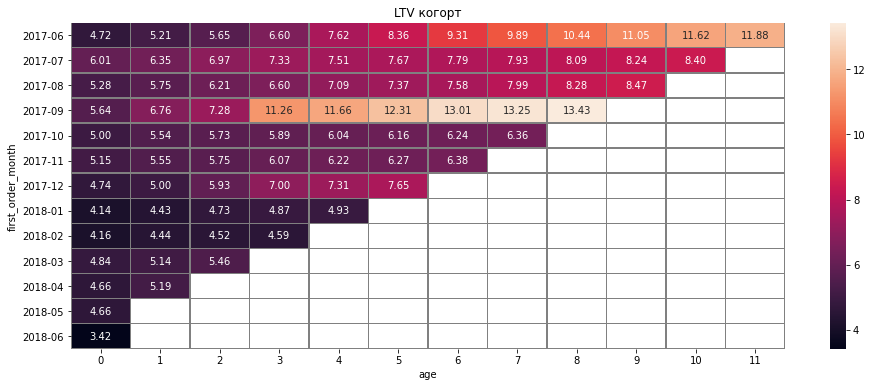

In [70]:
plt.figure(figsize=(16, 6));
plt.title('LTV когорт');
ax=sns.heatmap(ltv_pivot, annot=True, fmt='.2f', linewidths=0.5, linecolor='gray');
ax.set_yticklabels(ltv_pivot.index.strftime('%Y-%m'));

Мы не можем рассчитать LTV для всех когорт, так как длительность жизни некоторых из них вего лишь несколько месяцев. Примем к расчету среднего LTV когорты 2017 года.

In [71]:
mean_ltv = ltv_pivot.unstack().reset_index()
mean_ltv.columns = ['age', 'first_order_month', 'ltv']

In [72]:
mean_ltv.query('age ==(0, 1, 2, 3, 4, 5)\
and first_order_month ==\
("2017-06-01", "2017-07-01", "2017-08-01","2017-09-01","2017-10-01","2017-11-01","2017-12-01")')\
.groupby('age')['ltv'].mean()

age
0    5.220000
1    5.737143
2    6.217143
3    7.250000
4    7.635714
5    7.970000
Name: ltv, dtype: float64

К 6-му месяцу жизни средняя выручка от пользователей, совершивших покупку с июня по декабрь 2017 года составила 7,97.

In [73]:
# Посчитаем CAC каждой когорты. Сначала найдём суммарные расходы за каждый месяц, 
# а затем поделим их на количество покупателей в каждой когорте
# считаем расходы за месяц
monthly_costs = costs.groupby('month').sum()
monthly_costs.head(10)

,source_id,costs
month,,
2017-06-01,1020,18015.00
2017-07-01,1054,18240.59
2017-08-01,1054,14790.54
2017-09-01,1020,24368.91
2017-10-01,1054,36322.88
2017-11-01,1020,37907.88
2017-12-01,1054,38315.35
2018-01-01,1054,33518.52
2018-02-01,952,32723.03


In [74]:
# Добавим данные о расходах в отчёт и посчитаем CAC
report_new = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new.head(10)

,first_order_month,n_buyers,order_month,revenue,age,ltv,source_id,costs,cac
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,1020,18015.0,8.905091
1,2017-06-01,2023,2017-07-01,981.82,1,0.485329,1020,18015.0,8.905091
2,2017-06-01,2023,2017-08-01,885.34,2,0.437637,1020,18015.0,8.905091
3,2017-06-01,2023,2017-09-01,1931.30,3,0.954671,1020,18015.0,8.905091
4,2017-06-01,2023,2017-10-01,2068.58,4,1.022531,1020,18015.0,8.905091
5,2017-06-01,2023,2017-11-01,1487.92,5,0.735502,1020,18015.0,8.905091
6,2017-06-01,2023,2017-12-01,1922.74,6,0.950440,1020,18015.0,8.905091
7,2017-06-01,2023,2018-01-01,1176.56,7,0.581592,1020,18015.0,8.905091
8,2017-06-01,2023,2018-02-01,1119.15,8,0.553213,1020,18015.0,8.905091
9,2017-06-01,2023,2018-03-01,1225.51,9,0.605788,1020,18015.0,8.905091


In [75]:
# Рассчитаем ROMI: поделим LTV на CAC
report_new['romi'] = report_new['ltv'] / report_new['cac']
romi_pivot = report_new.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean')

romi_pivot.cumsum(axis=1).round(2)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,NaN
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68,0.70,0.74,0.77,0.78,NaN,NaN
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.30,1.38,1.40,1.42,NaN,NaN,NaN
2017-10-01,0.60,0.66,0.68,0.70,0.72,0.74,0.75,0.76,NaN,NaN,NaN,NaN
2017-11-01,0.55,0.60,0.62,0.65,0.67,0.68,0.69,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.54,0.57,0.68,0.80,0.84,0.87,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.42,0.45,0.48,0.49,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.46,0.49,0.50,0.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Читаем отчёт:
Июньская когорта окупилась на 7 месяц (ROMI = 1.05).
Сентябрьская когорта окупилась на 4 месяц (ROMI = 1.19).
Остальные когорты не окупились вовсе.

In [76]:
# Посчитаем среднюю когорту. Узнаем, как быстро в среднем когорты окупаются. 
# Усредним значения каждой колонки и «сложим» таблицу в единую строку методом mean(axis=0)
romi_pivot.cumsum(axis=1).mean(axis=0)

age
0     0.540816
1     0.581985
2     0.631069
3     0.719740
4     0.782946
5     0.859876
6     0.896819
7     0.969951
8     1.053871
9     0.964488
10    1.094658
11    1.333982
dtype: float64

В среднем когорты окупаются только к 8-му месяцу.

### Маркетинг

#### Сколько денег потратили? Всего / на каждый источник / по времени



In [77]:
total_costs = costs['costs'].sum()
print('За всё время маркетинговой компании потрачено', total_costs)

За всё время маркетинговой компании потрачено 329131.62


In [78]:
# добавим столбец с месяцем трат на рекламу
costs['month'] = costs['dt'].astype('datetime64[M]').dt.date
costs.head(10)

,source_id,dt,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01
5,1,2017-06-06,40.39,2017-06-01
6,1,2017-06-07,40.59,2017-06-01
7,1,2017-06-08,56.63,2017-06-01
8,1,2017-06-09,40.16,2017-06-01
9,1,2017-06-10,43.24,2017-06-01


In [79]:
# сгруппируем помесячно
month_costs = costs.groupby('month')['costs'].sum()

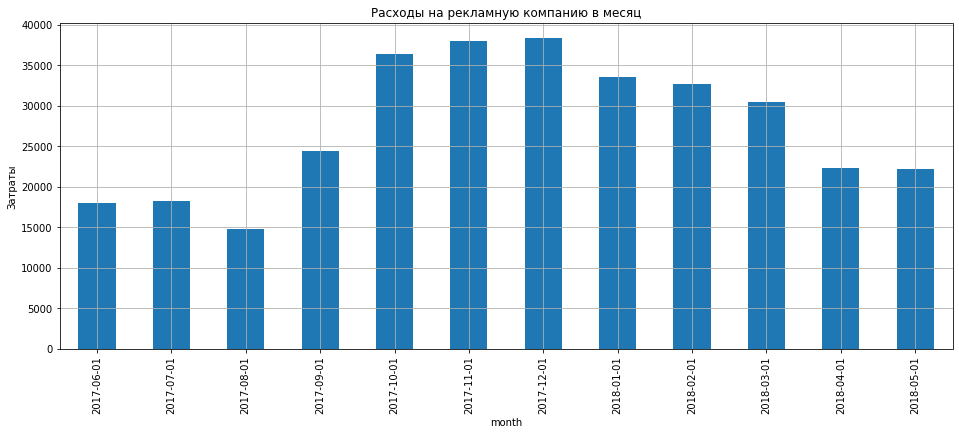

In [80]:
month_costs.plot(x='month', y='costs', kind='bar', figsize=(16, 6), grid=True);
plt.ylabel('Затраты');
plt.title('Расходы на рекламную компанию в месяц');

Из графика видно, что самые большие затраты на маркетинг приходятся с сентября по май.

Посмотрим как распределились затраты по рекламным ресурсам.

In [81]:
source_costs = costs.groupby('source_id')['costs'].sum()
source_costs

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

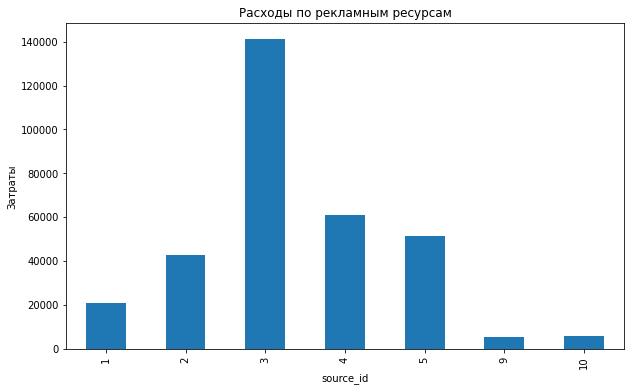

In [82]:
source_costs.plot(x='source_id', y='costs', kind='bar', figsize=(10, 6));
plt.ylabel('Затраты');
plt.title('Расходы по рекламным ресурсам');

#### Сколько стоило привлечение одного покупателя из каждого источника?

In [83]:
# из таблицы visits возьмём только uid и source_id, затем объединим с таблицей orders
# получим таблицу где для каждого пользователя получим рекламный источник, из которого он пришёл
uid_source = visits.groupby('uid')['source_id'].mean().astype('int')
order_source = pd.merge(orders, uid_source, on='uid').reset_index()
source_size = order_source.groupby('source_id').agg({'uid': 'nunique'})

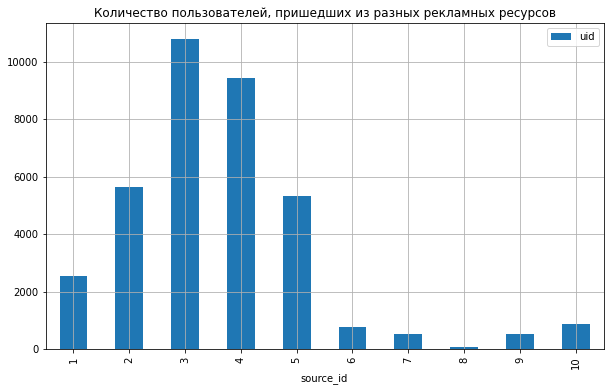

In [84]:
source_size.plot(kind='bar', figsize=(10, 6), grid=True);
plt.title('Количество пользователей, пришедших из разных рекламных ресурсов');

#### На сколько окупились расходы? (ROI)

Для того, чтобы ответить на этот вопрос сформируем таблицу, в которой для каждого юзера будет САС, идентификатор рекламного источника и затраты на этот рекламный источник.

In [85]:
costs_source_total = pd.merge(source_costs, source_size, on='source_id')
costs_source_total['cac'] = costs_source_total['costs'] / costs_source_total['uid']
costs_source_total

,costs,uid,cac
source_id,,,
1,20833.27,2551,8.166707
2,42806.04,5628,7.605906
3,141321.63,10795,13.091397
4,61073.60,9432,6.475148
5,51757.10,5337,9.697789
9,5517.49,533,10.351764
10,5822.49,885,6.579085


In [86]:
total_orders = order_source.groupby('source_id').agg({'revenue':'sum'}).reset_index()
roi = pd.merge(source_costs, total_orders, on = 'source_id')
roi['roi'] = (roi['revenue'] - roi['costs']) * 100 / roi['costs']
roi

,source_id,costs,revenue,roi
0,1,20833.27,36352.44,74.492242
1,2,42806.04,76215.84,78.049266
2,3,141321.63,58209.70,-58.810481
3,4,61073.60,45157.22,-26.060982
4,5,51757.10,25286.58,-51.143746
5,9,5517.49,1920.19,-65.198125
6,10,5822.49,2446.22,-57.986703


### Напишем вывод: порекомендуем маркетологам, куда и сколько им стоит вкладывать денег <a id="step3"></a>   

Обратим внимание на ключевые метрики ROI и CAC. 

Самая низкая стоимость привлечения клиента у источников 4, 10, 2 и 1. Их нужно масштабировать. Самая высокая стоимость привлечения у 3 источника, стоит отметить, что на него маркетологи потратили больше всего денежных средств, что нерационально.

Показатель возврата на маркетинговые инвестиции показывает, что окупились только 2 рекламных источника: 1 и 2.
Сооответсвенно, необходимо перенаправить денежные потоки именно на них по двум причинам: одна из самых низких стоимостей привлечения клиента, а главное - окупаемость.

Также стоит отметить такую метрику роста как коэффициент удержания. Он находится на весьма низком уровне. Чем выше retention rate, тем больше денег приносит пользователь. Маркетологам необходимо выработать механизм по удержанию пользователей сайта, для совершения ими повторных покупок.